## Model 4:
 - 56 x 75 x 3
 - mini_batch size = 256
 - 20 epochs
 - pretrained layers with mobile net v2
 - +6 top layers

In [1]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import os
from os import listdir
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
base_directory = "skin-cancer-mnist-ham10000"

test_directory = os.path.join(base_directory, 'image_data_test')
train_directory = os.path.join(base_directory, 'image_data_train')
validation_directory = os.path.join(base_directory, 'image_data_validation')
aug_train_directory = os.path.join(base_directory, 'image_data_train_augmented')
bal_validation_directory = os.path.join(base_directory, 'image_data_validation_balanced')

In [3]:
from keras.applications import MobileNetV2

In [4]:
prior = MobileNetV2(include_top =  False, weights = "imagenet", input_shape = (56, 75, 3))

W0824 17:59:25.579674 4674106816 deprecation_wrapper.py:119] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0824 17:59:25.615368 4674106816 deprecation_wrapper.py:119] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0824 17:59:25.630291 4674106816 deprecation_wrapper.py:119] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0824 17:59:25.704736 4674106816 deprecation_wrapper.py:119] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_s

In [5]:
model = Sequential()

model.add(prior)

model.add(Flatten())
# model.add(Dropout(rate = 0.5))

model.add(Dense(512, activation='relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(256, activation='relu'))
# model.add(Dropout(rate = 0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(64, activation='relu'))

model.add(Dense(7, activation='softmax'))

for layer in model.layers[0].layers:
    layer.trainable = False

W0824 17:59:41.304579 4674106816 deprecation.py:506] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 2, 3, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               3932672   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [7]:
adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy',
              optimizer = adam,
              metrics = ['acc'])

W0824 17:59:41.516655 4674106816 deprecation_wrapper.py:119] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
        aug_train_directory,
        target_size=(56, 75), 
        batch_size= 256,
        class_mode='categorical' 
)

validation_generator = val_datagen.flow_from_directory(
        bal_validation_directory,
        target_size=(56, 75),
        batch_size= 256,
        class_mode='categorical')

Found 26273 images belonging to 7 classes.
Found 196 images belonging to 7 classes.


In [10]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (256, 56, 75, 3)
labels batch shape: (256, 7)


In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [EarlyStopping(monitor= "val_loss", patience = 5, restore_best_weights= True),
             ReduceLROnPlateau(monitor="loss", patience = 2)]


In [12]:
import numpy as np

history = model.fit_generator(
      train_generator,
      steps_per_epoch=np.ceil(26273/256),
      epochs=20,
      validation_data=validation_generator,
      validation_steps= np.ceil(196/256),
      callbacks= callbacks,
)

W0824 17:59:44.891649 4674106816 deprecation.py:323] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
103/103 [==============================] - 262s 3s/step - loss: 1.7838 - acc: 0.2977 - val_loss: 1.6305 - val_acc: 0.3367
Epoch 2/20
103/103 [==============================] - 232s 2s/step - loss: 1.4499 - acc: 0.4450 - val_loss: 1.5391 - val_acc: 0.4235
Epoch 3/20
103/103 [==============================] - 239s 2s/step - loss: 1.3084 - acc: 0.5083 - val_loss: 1.4895 - val_acc: 0.4490
Epoch 4/20
103/103 [==============================] - 234s 2s/step - loss: 1.2192 - acc: 0.5462 - val_loss: 1.6002 - val_acc: 0.4439
Epoch 5/20
103/103 [==============================] - 222s 2s/step - loss: 1.1355 - acc: 0.5776 - val_loss: 1.5962 - val_acc: 0.4490
Epoch 6/20
103/103 [==============================] - 247s 2s/step - loss: 1.0705 - acc: 0.6067 - val_loss: 1.4200 - val_acc: 0.4898
Epoch 7/20
103/103 [==============================] - 242s 2s/step - loss: 1.0100 - acc: 0.6256 - val_loss: 1.4961 - val_acc: 0.4949
Epoch 8/20
103/103 [==============================] - 225s 2s/step - 

In [13]:
model.save("model_4.h5")

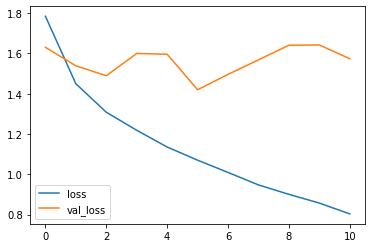

In [14]:
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend();

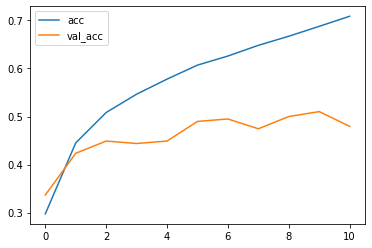

In [15]:
plt.plot(history.history["acc"], label = "acc")
plt.plot(history.history["val_acc"], label = "val_acc")
plt.legend();